In [3]:
## read the data
import scipy.io
data = scipy.io.loadmat('/Users/jinyanwei/Desktop/BP_Model/Data/Cuffless_BP_Estimation/part_1.mat')
##Can't be used data: patient_unable = []
## Some wrongs data: patient_better_dont_ues = [2]

In [290]:
import scipy.signal as signal
def chebyshev_filter(signal):
    # Define the filter order and cutoff frequency
    order = 4
    fs = 125  # Sample rate in Hz
    cutoff_freq = 20  # Cutoff frequency in Hz
    # Create the Chebyshev low-pass filter
    b, a = signal.cheby1(order, 0.5, cutoff_freq / (fs / 2), 'low', analog=False)
    return signal.lfilter(b, a, signal)

from scipy.signal import butter, filtfilt
def butter_filter(signal):
    fs = 125  # Sample rate
    cutoff = 5  # Cutoff frequency in Hz
    # Design the Butterworth low-pass filter
    nyquist = 0.5 * fs
    cutoff_norm = cutoff / nyquist
    b, a = butter(4, cutoff_norm, btype='low')
    return filtfilt(b, a, signal)

import numpy as np
def straighten_ecg(ecg_signal):
    detrended_ecg = np.subtract(ecg_signal, np.mean(ecg_signal))
    return detrended_ecg
    
import numpy as np
def normalize_sinal(ppg):
# Assuming ppg_signal and ecg_signal are your original PPG and ECG signals
    ppg_min = np.min(ppg)
    ppg_max = np.max(ppg)
    normalized_ppg = (ppg - ppg_min) / (ppg_max - ppg_min)
    return normalized_ppg

import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
def align_ppgbp(ppg_signal, bp_signal, ecg_signal, show=0): ## ppg_signal = ppg_normalized, bp_signal = bp_normalized, ecg_signal = ecg_normalized; get ppg_aligned, bp_aligned
    ori_ppg_peaks, _ = find_peaks(ppg_signal)
    ppg_peaks = np.array([ppg_peak for ppg_peak in ori_ppg_peaks if ppg_signal[ppg_peak] > 0.65])
    ori_bp_peaks, _ = find_peaks(bp_signal)
    bp_peaks = np.array([bp_peak for bp_peak in ori_bp_peaks if bp_signal[bp_peak] > 0.4])
    ori_ecg_peaks, _ = find_peaks(ecg_signal)
    ecg_peaks = np.array([ecg_peak for ecg_peak in ori_ecg_peaks if ecg_signal[ecg_peak] > 0.65])

    first_ecg_peak = ecg_peaks[0]
    #print(f'first ecg peak: {first_ecg_peak}')
    last_ecg_peak = ecg_peaks[-1]
    indices_ppg = np.argwhere(ppg_peaks[:10] > first_ecg_peak)
    first_ppg_peak = ppg_peaks[int(indices_ppg[0])]
    #print(f'first ppg peak: {first_ppg_peak}')
    indices_bp = np.argwhere(bp_peaks[:10] > first_ecg_peak)
    first_bp_peak = bp_peaks[int(indices_bp[0])]
    #print(f'first bp peak: {first_bp_peak}')
    ppg_bp_peaks_subtraction = abs(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+20] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+20])
    #print(ppg_bp_peaks_subtraction)
    distance_ppgbp = np.bincount(ppg_bp_peaks_subtraction).argmax()
    move_distance = max(ppg_bp_peaks_subtraction) - min(ppg_bp_peaks_subtraction)
    #print(move_distance)
    #print(bp_peaks[int(indices_bp[0]):int(indices_bp[0])+20] - ppg_peaks[int(indices_ppg[0]):int(indices_ppg[0])+20])
    #print(f'distance:{distance_ppgbp}')
    if first_bp_peak > first_ppg_peak:
        bp_aligned = bp_signal[distance_ppgbp:]
        ppg_aligned = ppg_signal
    elif first_bp_peak < first_ppg_peak:
        bp_aligned = bp_signal
        ppg_aligned = ppg_signal[distance_ppgbp:]
    else:
        bp_aligned = bp_signal
        ppg_aligned = ppg_signal
    #print(f'ppg len: {len(ppg_aligned)}')
    #print(f'bp len: {len(bp_aligned)}')
    min_len = min(len(bp_aligned), len(ppg_aligned))
    bp_aligned = bp_aligned[:min_len]
    ppg_aligned = ppg_aligned[:min_len]
    ecg_aligned = ecg_signal[move_distance:(min_len+move_distance)]
    #print(ecg_aligned)
    if show == 1:
        plt.figure(figsize=(30, 6))
        plt.plot(ppg_signal, label='PPG')
        plt.plot(bp_signal, label='BP')
        plt.plot(ecg_signal, label='ECG')
        plt.scatter(ppg_peaks, ppg_signal[ppg_peaks], color='c', marker='o', label='Aligned PPG Peaks')
        plt.scatter(bp_peaks, bp_signal[bp_peaks], color='orange', marker='o', label='Aligned BP Peaks')
        plt.scatter(ecg_peaks, ecg_signal[ecg_peaks], color='green', marker='o', label='Aligned BP Peaks')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

        plt.figure(figsize=(30, 6))
        plt.plot(ppg_aligned, label='PPG')
        plt.plot(bp_aligned, label='BP')
        plt.plot(ecg_aligned, label='ECG')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()
        plt.show()

    return ppg_aligned, bp_aligned, ecg_aligned


'''Peak Detection:

For PPG, you can detect peaks using the scipy.signal.find_peaks function or other peak detection algorithms.
For ECG, you can detect R-peaks using the scipy.signal.find_peaks function or ECG-specific algorithms like the Pan-Tompkins algorithm.
Frequency Analysis:

Apply Fourier Transform to obtain the frequency spectrum of the signals. You can use the np.fft.fft function in NumPy.
Extract frequency-domain features such as dominant frequency, spectral power, or frequency bands of interest.
Time-Domain Features:

Calculate statistical features such as mean, median, standard deviation, and variance.
Compute heart rate-related features like heart rate variability (HRV) metrics (e.g., standard deviation of NN intervals, RMSSD).
Other Features:

Compute waveform-related features like rise time, fall time, amplitude, and area under the curve.
Calculate morphological features such as QRS duration, PR interval, T-wave amplitude, etc.'''


import matplotlib.pyplot as plt
def show_one(signal1):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1)
    return plt.show()
def show_two(signal1, signal2):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.legend()
    return plt.show()
def show_three(signal1, signal2, signal3):
    fig = plt.figure(figsize=(30,6))
    plt.plot(signal1, label='1')
    plt.plot(signal2, label='2')
    plt.plot(signal3, label='3')
    plt.legend()
    return plt.show()

In [294]:
## data['p'].shape:(1, 1000); patient_data = data['p'][0,patient_num], shape:(3, points)
patient_data = data['p'][0,1]
ppg = patient_data[0]
bp = patient_data[1]
ecg = patient_data[2]

ecg_detrened = straighten_ecg(ecg)
ppg_normalized = normalize_sinal(ppg)
bp_normalized = normalize_sinal(bp)
ecg_normalized = normalize_sinal(ecg_detrened)
ppg_aligned, bp_aligned, ecg_aligned = align_ppgbp(ppg_signal = ppg_normalized[:3000], bp_signal = bp_normalized[:3000], ecg_signal = ecg_normalized[:3000], show=0)

[1, 3, 4]

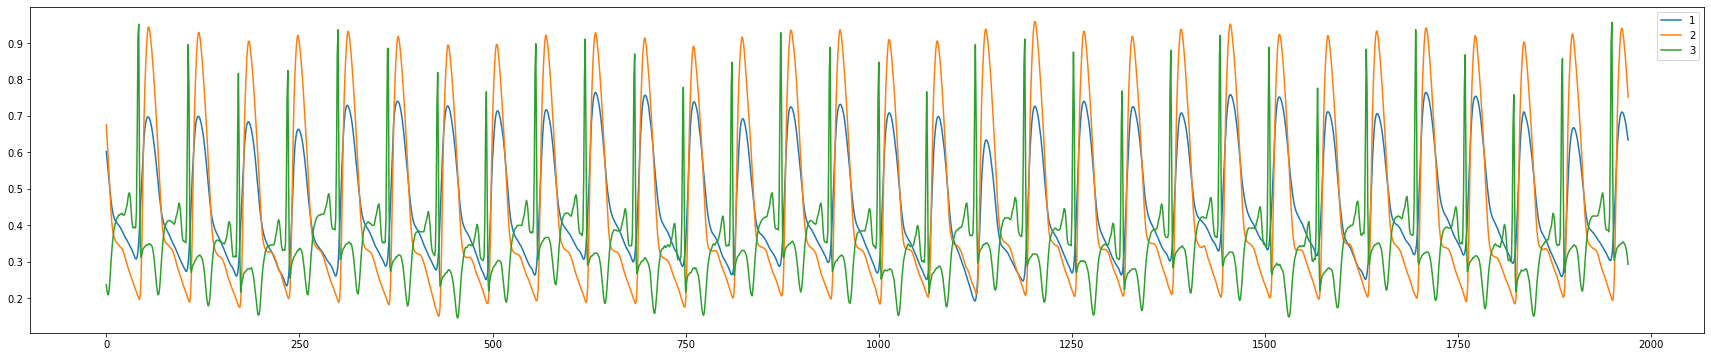

In [293]:
show_three(ppg_aligned[:5000], bp_aligned[:5000], ecg_aligned[:5000])